## Import

In [1]:
# importing the libraries
import os
import pandas as pd
import numpy as np
from itertools import chain
from IPython.display import clear_output

# for reading and displaying images
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# PyTorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# models
from src.models.model_util import load_model, save_checkpoint

# other files
from src.training.run import *
from src.data.data_util import *

# Torch
from torch.optim import *
import torch.optim as optim
from torchsummary import summary
# from tensorboardX import SummaryWriter

# Maintenance
# import mlflow
# from DeepNotion.build import *

# CAM - M3dCam
# from medcam import medcam

## Load Configurations

In [2]:
from src.config import *
cfg = load_config()

## MLFlow Init

In [3]:
exp_name = '3dcnn_smri_comparison_test'
try:
    mlflow.create_experiment(name=exp_name)
except:
    print('Existing experiment')
    
mlflow.set_experiment(exp_name)

Existing experiment


Pararmeters to write

In [4]:
params = dict()
for name, value in cfg.get_dict().items():
    if name not in ['notion']:
        params[name] = str(value)

## Tracking on Notion

In [5]:
cfg['notion']['use'] = False

### Load Preexisting page

In [6]:
if cfg['notion']['use']:
    root, client = login(cfg['notion'])
    page = root.children[-1]

### Make New Page

In [18]:
if cfg['notion']['use']:

    print(today())
    root, client = login(cfg['notion'])
    page = make_page(root)

    toggle = page.children.add_new(ToggleBlock, title='Configuration')

    print("Saving Configurations ...")
    for name, value in cfg.get_dict().items():
        if name not in ['notion']:
            txt = '**' + name + '** ' + str(value)
            print(txt)
            toggle.children.add_new(BulletedListBlock, title=txt)

#     fold_db = make_db(page, schema=cfg.schema)
#     test_db = make_db(page, schema=cfg.test_schema)

2021.02.08.20:14


## Train

### No Fold

In [3]:
model, cfg.device = load_model(cfg.model_name, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

trn_dp, aug_dp, tst_dp = DataPacket(), DataPacket(), DataPacket()
aug_dp.delete('corr')

# mlflow.start_run(run_name='Affine+Flip Uniform with (5, 1.5), Full')
cfg['augmentation'] = {
    'affine': 0,
    'flip': 0,
    'elastic_deform': 1
}
# mlflow.log_params(params)

Model Resnet is selected.


Epoch 1 / 100, BEST MAE 10.000
[train] 99.0 sec [valid] 12.8 sec 
[TRAIN]:: Loss=3150.764 Mae=54.042 Rmse=56.022 Corr=0.720 
[TEST ]:: Loss=3160.100 Mae=53.874 Rmse=56.150 Corr=0.782 


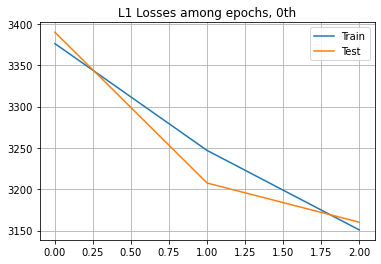

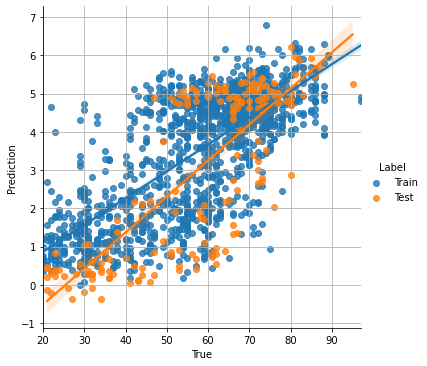

Epoch 2 / 100, BEST MAE 10.000
[train] 97.9 sec [valid] 12.5 sec 
[TRAIN]:: Loss=3057.591 Mae=53.234 Rmse=55.184 Corr=0.743 
[TEST ]:: Loss=3139.469 Mae=53.665 Rmse=55.970 Corr=0.678 
Epoch 3 / 100, BEST MAE 10.000
[train] 96.9 sec [valid] 12.4 sec 
[TRAIN]:: Loss=2965.863 Mae=52.414 Rmse=54.346 Corr=0.756 
[TEST ]:: Loss=3013.839 Mae=52.534 Rmse=54.835 Corr=0.711 
Epoch 4 / 100, BEST MAE 10.000
[train] 96.8 sec [valid] 12.6 sec 
[TRAIN]:: Loss=2867.889 Mae=51.537 Rmse=53.436 Corr=0.775 
[TEST ]:: Loss=2852.563 Mae=51.122 Rmse=53.341 Corr=0.806 
Epoch 5 / 100, BEST MAE 10.000


In [ ]:
best_mae = cfg.best_mae
fold = None
db = make_db(page, client=client, schema=cfg['notion']['no_fold_aug_schema'], title='Results') if cfg['notion']['use'] else None
for e in range(cfg.epochs):
    
    start_time = time.time()
    print(f'Epoch {e+1} / {cfg.epochs}, BEST MAE {best_mae:.3f}')
    
    model, trn_dp, trn_res = train(model, optimizer, fn_lst, trn_dp, cfg, fold=fold)
    model, tst_dp, tst_res = valid(model, fn_lst, tst_dp, cfg, fold=fold)
    elapsed_time = round(time.time() - start_time, 3)
       
    if best_mae > tst_dp.mae[-1]:
        
        best_mae = tst_dp.mae[-1]
        model_name = f'{cfg.model_name}_ep{e}-{cfg.epochs}_sd{cfg.seed}_mae{best_mae:.3f}.pt'
        save_checkpoint(cfg.get_dict(), model_name, is_best=True)
        
    df = pd.concat([make_df(trn_res, 'Train'),
#                     make_df(aug_res, 'Aug'),
                    make_df(tst_res, 'Test')], ignore_index=True)
    
    trn_dp.corr.update(df[df['Label'] == 'Train'].corr().Prediction['True'])
    trn_dp.refresh()
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()

    if e % 1 == 0:
        trn_dp.info('train')
#         aug_dp.info('augme')
        tst_dp.info('test ')

    if e % 5 == 0:
        plt.title(f"L1 Losses among epochs, {e}th")
        plt.plot(list(trn_dp.loss), label='Train')
        plt.plot(list(tst_dp.loss), label='Test')
        plt.grid(); plt.legend()

        sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
        plt.grid()
        plt.show()
        
        if db:
            data = gather_data(e=e, time=elapsed_time, cfg=cfg,
                               train=trn_dp, valid=tst_dp, aug=aug_dp)
            write_db(db, data)
    
#     metrics = mlflow_data(time=elapsed_time, train=trn_dp, valid=tst_dp)
#     mlflow.log_metrics(metrics, e)
    
    torch.cuda.empty_cache()
    
# mlflow.end_run()

### kFold

In [8]:
models = []
packets = []
tst_dp = DataPacket()

#### Whole Run

In [9]:
# test_db = make_db(page, client=client, schema=cfg['notion']['test_schema'], title='Test') if cfg['notion']['use'] else None
test_db = page.children[2]
fold_db = make_db(page, client=client, schema=cfg['notion']['schema'], title=f'Fold {fold+1}') if cfg['notion']['use'] else None

Fold 17 / 20
Model Resnet is selected.
Epoch 1 / 100, BEST MAE 10.000
[train] 44.9 sec [train] 84.7 sec [eval] 13.6 sec 
[TRAIN]:: Loss=3535.974 Mae=57.203 Rmse=59.406 Corr=0.525 
[AUGME]:: Loss=3453.199 Mae=56.457 Rmse=58.704 
[VALID]:: Loss=3406.208 Mae=56.093 Rmse=58.249 Corr=-0.395 
Epoch 2 / 100, BEST MAE 10.000
[train] 52.2 sec [train] 74.2 sec [eval] 12.6 sec 
[TRAIN]:: Loss=3393.685 Mae=56.119 Rmse=58.194 Corr=0.696 
[AUGME]:: Loss=3359.967 Mae=55.629 Rmse=57.904 
[VALID]:: Loss=3342.861 Mae=55.525 Rmse=57.703 Corr=-0.516 
Epoch 3 / 100, BEST MAE 10.000
[train] 50.1 sec [train] 75.1 sec [eval] 12.6 sec 
[TRAIN]:: Loss=3301.826 Mae=55.308 Rmse=57.399 Corr=0.715 
[AUGME]:: Loss=3285.529 Mae=54.955 Rmse=57.258 
[VALID]:: Loss=3279.498 Mae=54.952 Rmse=57.152 Corr=-0.511 
Epoch 4 / 100, BEST MAE 10.000
[train] 51.8 sec [train] 75.6 sec [eval] 12.7 sec 
[TRAIN]:: Loss=3215.878 Mae=54.546 Rmse=56.646 Corr=0.730 
[AUGME]:: Loss=3209.370 Mae=54.261 Rmse=56.589 
[VALID]:: Loss=3204.525 M

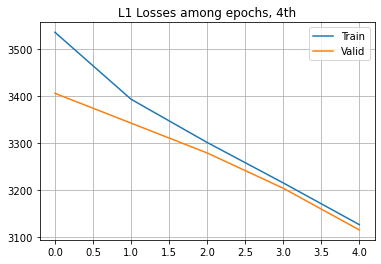

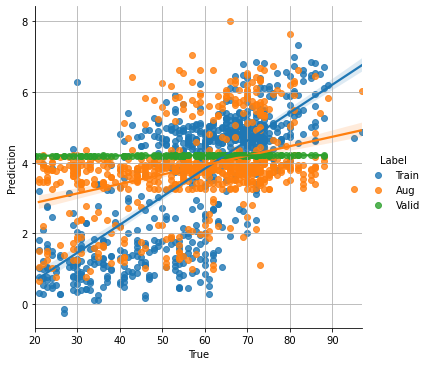

Epoch 6 / 100, BEST MAE 10.000
[train] 51.5 sec [train] 75.7 sec [eval] 12.5 sec 
[TRAIN]:: Loss=3034.850 Mae=52.927 Rmse=55.024 Corr=0.742 
[AUGME]:: Loss=3046.183 Mae=52.746 Rmse=55.129 
[VALID]:: Loss=3006.511 Mae=52.411 Rmse=54.713 Corr=0.525 
Epoch 7 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 74.9 sec [eval] 12.6 sec 
[TRAIN]:: Loss=2941.687 Mae=52.088 Rmse=54.171 Corr=0.754 
[AUGME]:: Loss=2957.360 Mae=51.920 Rmse=54.318 
[VALID]:: Loss=2846.995 Mae=50.857 Rmse=53.236 Corr=-0.548 
Epoch 8 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 75.4 sec [eval] 12.4 sec 
[TRAIN]:: Loss=2846.088 Mae=51.216 Rmse=53.282 Corr=0.759 
[AUGME]:: Loss=2865.573 Mae=51.055 Rmse=53.466 
[VALID]:: Loss=2567.093 Mae=48.046 Rmse=50.542 Corr=0.557 
Epoch 9 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 75.2 sec [eval] 12.4 sec 
[TRAIN]:: Loss=2740.918 Mae=50.246 Rmse=52.285 Corr=0.768 
[AUGME]:: Loss=2765.822 Mae=50.121 Rmse=52.524 
[VALID]:: Loss=2503.552 Mae=47.368 Rmse=49.910 Corr=-0.047 
Epoch 

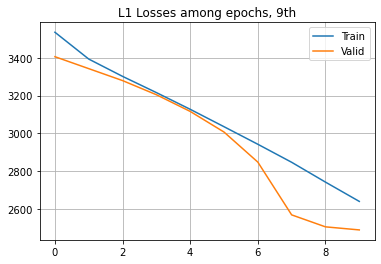

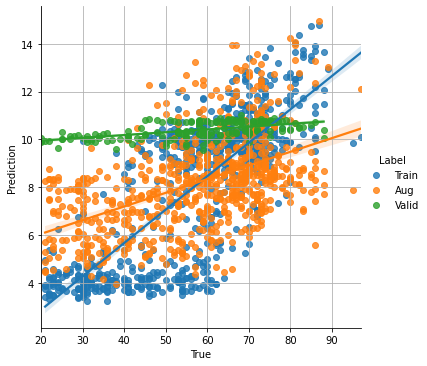

Epoch 11 / 100, BEST MAE 10.000
[train] 51.1 sec [train] 77.1 sec [eval] 12.6 sec 
[TRAIN]:: Loss=2528.555 Mae=48.238 Rmse=50.213 Corr=0.785 
[AUGME]:: Loss=2567.732 Mae=48.209 Rmse=50.604 
[VALID]:: Loss=2355.618 Mae=45.862 Rmse=48.409 Corr=0.576 
Epoch 12 / 100, BEST MAE 10.000
[train] 52.1 sec [train] 74.6 sec [eval] 12.5 sec 
[TRAIN]:: Loss=2418.360 Mae=47.179 Rmse=49.104 Corr=0.797 
[AUGME]:: Loss=2461.488 Mae=47.152 Rmse=49.543 
[VALID]:: Loss=2284.171 Mae=45.156 Rmse=47.669 Corr=0.609 
Epoch 13 / 100, BEST MAE 10.000
[train] 50.7 sec [train] 74.8 sec [eval] 12.3 sec 
[TRAIN]:: Loss=2304.443 Mae=46.034 Rmse=47.930 Corr=0.798 
[AUGME]:: Loss=2353.940 Mae=46.039 Rmse=48.445 
[VALID]:: Loss=2442.034 Mae=46.896 Rmse=49.296 Corr=0.568 
Epoch 14 / 100, BEST MAE 10.000
[train] 50.5 sec [train] 76.6 sec [eval] 12.5 sec 
[TRAIN]:: Loss=2181.715 Mae=44.797 Rmse=46.631 Corr=0.817 
[AUGME]:: Loss=2238.315 Mae=44.866 Rmse=47.237 
[VALID]:: Loss=2220.805 Mae=44.682 Rmse=47.008 Corr=0.579 
Epoc

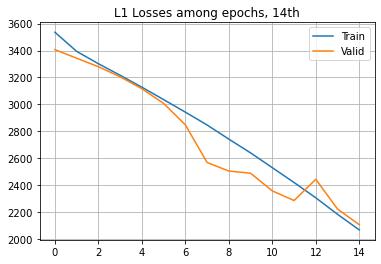

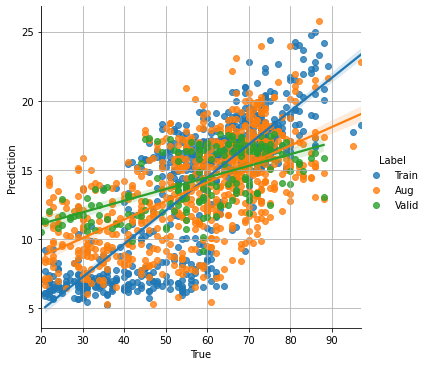

Epoch 16 / 100, BEST MAE 10.000
[train] 51.6 sec [train] 75.5 sec [eval] 12.5 sec 
[TRAIN]:: Loss=1943.757 Mae=42.299 Rmse=44.005 Corr=0.842 
[AUGME]:: Loss=2001.724 Mae=42.375 Rmse=44.662 
[VALID]:: Loss=2890.072 Mae=51.535 Rmse=53.647 Corr=0.509 
Epoch 17 / 100, BEST MAE 10.000
[train] 51.5 sec [train] 75.0 sec [eval] 12.4 sec 
[TRAIN]:: Loss=1824.537 Mae=40.969 Rmse=42.629 Corr=0.848 
[AUGME]:: Loss=1893.610 Mae=41.169 Rmse=43.435 
[VALID]:: Loss=1693.284 Mae=37.853 Rmse=41.009 Corr=-0.203 
Epoch 18 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 74.5 sec [eval] 12.2 sec 
[TRAIN]:: Loss=1707.683 Mae=39.679 Rmse=41.235 Corr=0.874 
[AUGME]:: Loss=1785.979 Mae=39.877 Rmse=42.177 
[VALID]:: Loss=1661.894 Mae=38.035 Rmse=40.644 Corr=0.639 
Epoch 19 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 75.1 sec [eval] 12.5 sec 
[TRAIN]:: Loss=1590.092 Mae=38.305 Rmse=39.782 Corr=0.889 
[AUGME]:: Loss=1679.117 Mae=38.655 Rmse=40.888 
[VALID]:: Loss=2006.335 Mae=42.540 Rmse=44.678 Corr=0.568 
Epo

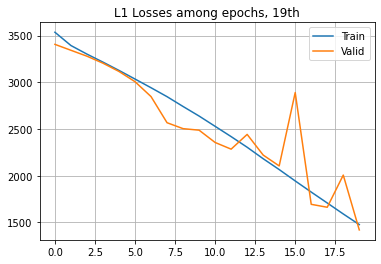

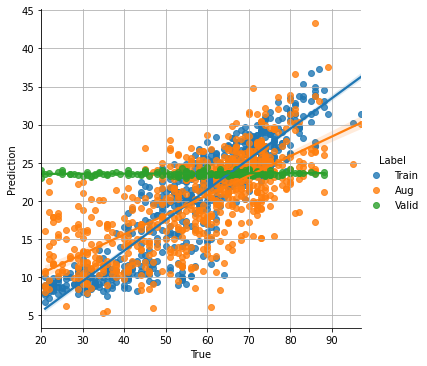

Epoch 21 / 100, BEST MAE 10.000
[train] 50.8 sec [train] 76.8 sec [eval] 12.6 sec 
[TRAIN]:: Loss=1365.288 Mae=35.584 Rmse=36.847 Corr=0.923 
[AUGME]:: Loss=1467.777 Mae=36.054 Rmse=38.217 
[VALID]:: Loss=1186.994 Mae=31.276 Rmse=34.317 Corr=0.634 
Epoch 22 / 100, BEST MAE 10.000
[train] 51.8 sec [train] 75.7 sec [eval] 12.6 sec 
[TRAIN]:: Loss=1265.024 Mae=34.298 Rmse=35.460 Corr=0.930 
[AUGME]:: Loss=1369.112 Mae=34.772 Rmse=36.905 
[VALID]:: Loss=1138.508 Mae=30.443 Rmse=33.604 Corr=0.594 
Epoch 23 / 100, BEST MAE 10.000
[train] 51.2 sec [train] 75.7 sec [eval] 12.8 sec 
[TRAIN]:: Loss=1167.114 Mae=32.965 Rmse=34.050 Corr=0.940 
[AUGME]:: Loss=1273.725 Mae=33.474 Rmse=35.590 
[VALID]:: Loss=1644.492 Mae=38.458 Rmse=40.453 Corr=0.629 
Epoch 24 / 100, BEST MAE 10.000
[train] 51.4 sec [train] 74.8 sec [eval] 12.8 sec 
[TRAIN]:: Loss=1071.544 Mae=31.581 Rmse=32.615 Corr=0.938 
[AUGME]:: Loss=1185.232 Mae=32.192 Rmse=34.317 
[VALID]:: Loss=1363.151 Mae=34.555 Rmse=36.815 Corr=0.651 
Epoc

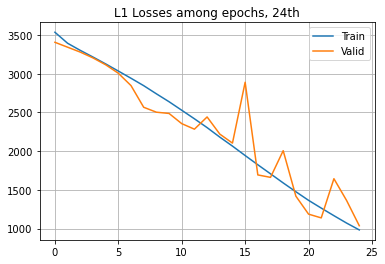

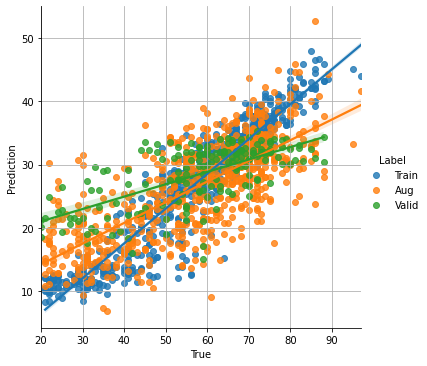

Epoch 26 / 100, BEST MAE 10.000
[train] 50.6 sec [train] 78.0 sec [eval] 13.0 sec 
[TRAIN]:: Loss=894.310 Mae=28.887 Rmse=29.773 Corr=0.951 
[AUGME]:: Loss=1028.840 Mae=29.766 Rmse=31.964 
[VALID]:: Loss=816.308 Mae=25.419 Rmse=28.432 Corr=0.650 
Epoch 27 / 100, BEST MAE 10.000
[train] 54.0 sec [train] 84.1 sec [eval] 12.6 sec 
[TRAIN]:: Loss=820.124 Mae=27.603 Rmse=28.499 Corr=0.944 
[AUGME]:: Loss=939.399 Mae=28.469 Rmse=30.529 
[VALID]:: Loss=660.676 Mae=22.735 Rmse=25.562 Corr=0.674 
Epoch 28 / 100, BEST MAE 10.000
[train] 55.0 sec [train] 81.8 sec [eval] 14.1 sec 
[TRAIN]:: Loss=740.337 Mae=26.190 Rmse=27.065 Corr=0.946 
[AUGME]:: Loss=864.566 Mae=27.199 Rmse=29.279 
[VALID]:: Loss=690.397 Mae=23.227 Rmse=26.133 Corr=0.682 
Epoch 29 / 100, BEST MAE 10.000
[train] 53.0 sec [train] 78.8 sec [eval] 13.0 sec 
[TRAIN]:: Loss=666.539 Mae=24.830 Rmse=25.667 Corr=0.949 
[AUGME]:: Loss=793.189 Mae=25.992 Rmse=28.036 
[VALID]:: Loss=1111.810 Mae=30.938 Rmse=33.240 Corr=0.645 
Epoch 30 / 100

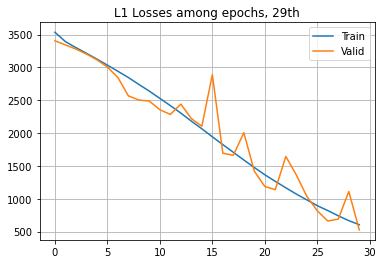

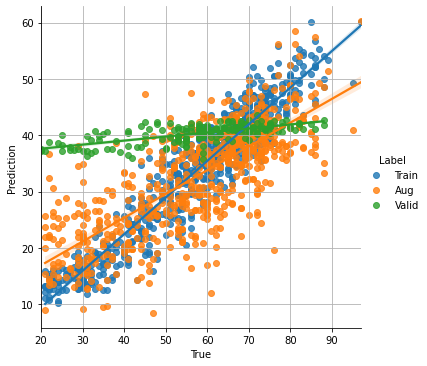

Epoch 31 / 100, BEST MAE 10.000
[train] 52.2 sec [train] 77.3 sec [eval] 12.3 sec 
[TRAIN]:: Loss=544.218 Mae=22.336 Rmse=23.160 Corr=0.952 
[AUGME]:: Loss=674.786 Mae=23.778 Rmse=25.837 
[VALID]:: Loss=446.511 Mae=18.642 Rmse=21.010 Corr=0.623 
Epoch 32 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 73.0 sec [eval] 12.2 sec 
[TRAIN]:: Loss=484.775 Mae=21.037 Rmse=21.844 Corr=0.956 
[AUGME]:: Loss=611.464 Mae=22.608 Rmse=24.580 
[VALID]:: Loss=347.534 Mae=16.381 Rmse=18.545 Corr=0.674 
Epoch 33 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 73.4 sec [eval] 12.4 sec 
[TRAIN]:: Loss=423.043 Mae=19.707 Rmse=20.378 Corr=0.963 
[AUGME]:: Loss=561.299 Mae=21.429 Rmse=23.552 
[VALID]:: Loss=327.745 Mae=15.893 Rmse=18.005 Corr=0.688 
Epoch 34 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 72.8 sec [eval] 12.3 sec 
[TRAIN]:: Loss=374.785 Mae=18.570 Rmse=19.157 Corr=0.968 
[AUGME]:: Loss=514.886 Mae=20.500 Rmse=22.546 
[VALID]:: Loss=340.313 Mae=16.122 Rmse=18.361 Corr=0.093 
Epoch 35 / 100, 

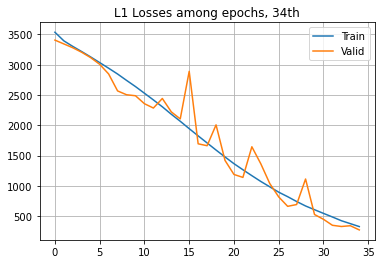

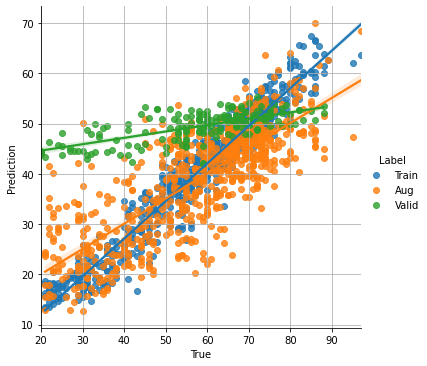

Epoch 36 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 74.2 sec [eval] 12.3 sec 
[TRAIN]:: Loss=281.623 Mae=16.049 Rmse=16.547 Corr=0.971 
[AUGME]:: Loss=413.608 Mae=18.266 Rmse=20.175 
[VALID]:: Loss=250.393 Mae=13.441 Rmse=15.740 Corr=0.673 
Epoch 37 / 100, BEST MAE 10.000
[train] 50.6 sec [train] 74.2 sec [eval] 12.2 sec 
[TRAIN]:: Loss=241.505 Mae=14.819 Rmse=15.284 Corr=0.973 
[AUGME]:: Loss=379.932 Mae=17.422 Rmse=19.326 
[VALID]:: Loss=241.659 Mae=13.174 Rmse=15.459 Corr=0.683 
Epoch 38 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 74.3 sec [eval] 12.3 sec 
[TRAIN]:: Loss=215.224 Mae=13.835 Rmse=14.406 Corr=0.968 
[AUGME]:: Loss=365.391 Mae=16.838 Rmse=18.951 
[VALID]:: Loss=1516.388 Mae=36.371 Rmse=38.819 Corr=0.553 
Epoch 39 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 72.9 sec [eval] 12.4 sec 
[TRAIN]:: Loss=184.283 Mae=12.748 Rmse=13.296 Corr=0.969 
[AUGME]:: Loss=305.607 Mae=15.302 Rmse=17.288 
[VALID]:: Loss=247.061 Mae=13.197 Rmse=15.634 Corr=0.674 
Epoch 40 / 100,

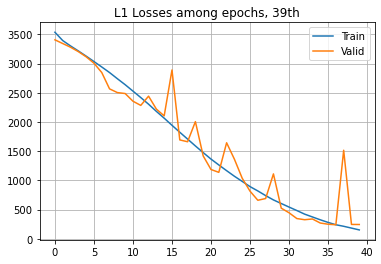

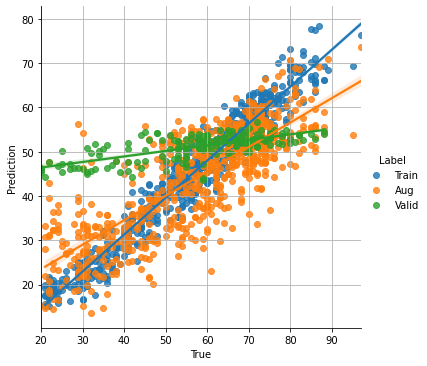

Epoch 41 / 100, BEST MAE 10.000
[train] 49.3 sec [train] 72.6 sec [eval] 12.2 sec 
[TRAIN]:: Loss=131.028 Mae=10.546 Rmse=11.112 Corr=0.969 
[AUGME]:: Loss=255.830 Mae=13.856 Rmse=15.818 
[VALID]:: Loss=205.964 Mae=11.315 Rmse=14.225 Corr=0.676 
Epoch 42 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 73.7 sec [eval] 12.2 sec 
[TRAIN]:: Loss=108.988 Mae=9.570 Rmse=10.079 Corr=0.971 
[AUGME]:: Loss=245.747 Mae=13.345 Rmse=15.505 
[VALID]:: Loss=245.140 Mae=13.208 Rmse=15.571 Corr=0.669 
Epoch 43 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 72.1 sec [eval] 12.3 sec 
[TRAIN]:: Loss=94.933 Mae=8.658 Rmse=9.398 Corr=0.962 
[AUGME]:: Loss=219.843 Mae=12.599 Rmse=14.607 
[VALID]:: Loss=224.109 Mae=11.843 Rmse=14.833 Corr=0.658 
Epoch 44 / 100, BEST MAE 10.000
[train] 49.3 sec [train] 72.0 sec [eval] 12.3 sec 
[TRAIN]:: Loss=77.820 Mae=7.802 Rmse=8.440 Corr=0.967 
[AUGME]:: Loss=195.905 Mae=11.814 Rmse=13.787 
[VALID]:: Loss=182.122 Mae=10.778 Rmse=13.390 Corr=0.690 
Epoch 45 / 100, BEST MA

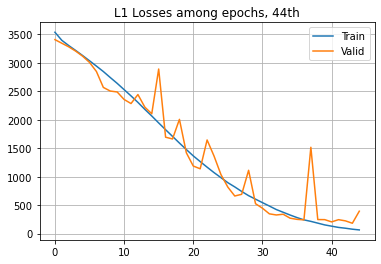

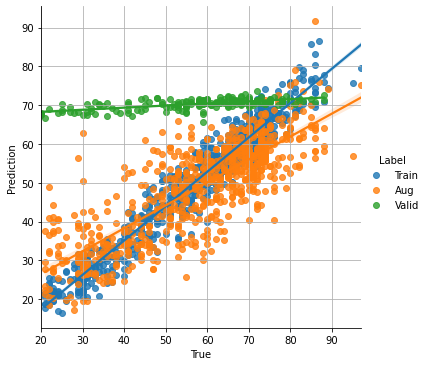

Epoch 46 / 100, BEST MAE 10.000
[train] 49.9 sec [train] 72.1 sec [eval] 12.2 sec 
[TRAIN]:: Loss=52.792 Mae=6.222 Rmse=6.790 Corr=0.972 
[AUGME]:: Loss=159.146 Mae=10.550 Rmse=12.421 
[VALID]:: Loss=175.414 Mae=10.513 Rmse=13.142 Corr=0.681 
Epoch 47 / 100, BEST MAE 10.000
[train] 49.7 sec [train] 71.5 sec [eval] 12.3 sec 
[TRAIN]:: Loss=41.872 Mae=5.500 Rmse=5.992 Corr=0.974 
[AUGME]:: Loss=141.762 Mae=9.840 Rmse=11.676 
[VALID]:: Loss=206.345 Mae=10.982 Rmse=14.207 Corr=0.680 
Epoch 48 / 100, BEST MAE 10.000
[train] 49.5 sec [train] 72.0 sec [eval] 12.3 sec 
[TRAIN]:: Loss=36.285 Mae=4.989 Rmse=5.559 Corr=0.972 
[AUGME]:: Loss=135.271 Mae=9.503 Rmse=11.402 
[VALID]:: Loss=424.562 Mae=15.658 Rmse=20.334 Corr=0.411 
Epoch 49 / 100, BEST MAE 10.000
[train] 49.8 sec [train] 78.7 sec [eval] 13.2 sec 
[TRAIN]:: Loss=30.737 Mae=4.536 Rmse=5.096 Corr=0.972 
[AUGME]:: Loss=126.253 Mae=9.105 Rmse=10.989 
[VALID]:: Loss=328.563 Mae=13.560 Rmse=17.885 Corr=0.620 
Epoch 50 / 100, BEST MAE 10.000

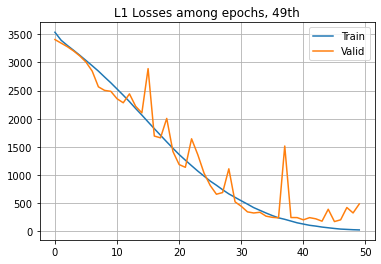

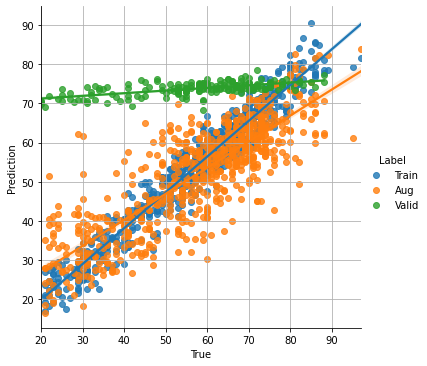

Epoch 51 / 100, BEST MAE 10.000
[train] 49.6 sec [train] 69.0 sec [eval] 12.2 sec 
[TRAIN]:: Loss=25.243 Mae=4.125 Rmse=4.697 Corr=0.967 
[AUGME]:: Loss=105.450 Mae=8.192 Rmse=10.037 
[VALID]:: Loss=645.741 Mae=20.831 Rmse=25.174 Corr=0.606 
Epoch 52 / 100, BEST MAE 10.000
[train] 49.2 sec [train] 68.7 sec [eval] 12.4 sec 
[TRAIN]:: Loss=21.615 Mae=3.713 Rmse=4.282 Corr=0.971 
[AUGME]:: Loss=101.168 Mae=7.963 Rmse=9.854 
[VALID]:: Loss=391.831 Mae=15.261 Rmse=19.568 Corr=0.640 
Epoch 53 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 67.0 sec [eval] 12.2 sec 
[TRAIN]:: Loss=20.204 Mae=3.543 Rmse=4.178 Corr=0.968 
[AUGME]:: Loss=99.089 Mae=7.793 Rmse=9.725 
[VALID]:: Loss=652.777 Mae=21.130 Rmse=25.325 Corr=0.604 
Epoch 54 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 65.6 sec [eval] 12.2 sec 
[TRAIN]:: Loss=19.111 Mae=3.462 Rmse=4.071 Corr=0.969 
[AUGME]:: Loss=99.612 Mae=7.898 Rmse=9.773 
[VALID]:: Loss=616.919 Mae=20.064 Rmse=24.592 Corr=0.447 
Epoch 55 / 100, BEST MAE 10.000
[trai

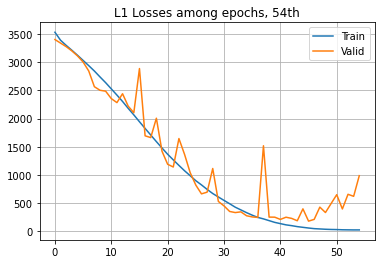

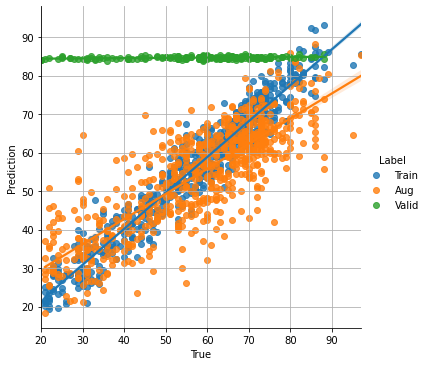

Epoch 56 / 100, BEST MAE 10.000
[train] 49.4 sec [train] 66.1 sec [eval] 12.9 sec 
Saving ...
[TRAIN]:: Loss=22.224 Mae=3.710 Rmse=4.432 Corr=0.960 
[AUGME]:: Loss=96.302 Mae=7.647 Rmse=9.615 
[VALID]:: Loss=136.423 Mae=9.640 Rmse=11.594 Corr=0.737 
Epoch 57 / 100, BEST MAE 9.640
[train] 49.9 sec [train] 66.4 sec [eval] 13.2 sec 
[TRAIN]:: Loss=21.739 Mae=3.777 Rmse=4.445 Corr=0.960 
[AUGME]:: Loss=91.072 Mae=7.341 Rmse=9.273 
[VALID]:: Loss=632.142 Mae=20.428 Rmse=24.898 Corr=0.474 
Epoch 58 / 100, BEST MAE 9.640
[train] 55.5 sec [train] 79.2 sec [eval] 12.6 sec 
[TRAIN]:: Loss=24.651 Mae=3.976 Rmse=4.779 Corr=0.955 
[AUGME]:: Loss=93.709 Mae=7.452 Rmse=9.447 
[VALID]:: Loss=812.455 Mae=23.886 Rmse=28.261 Corr=0.247 
Epoch 59 / 100, BEST MAE 9.640
[train] 54.6 sec [train] 74.8 sec [eval] 13.8 sec 
[TRAIN]:: Loss=22.600 Mae=3.840 Rmse=4.566 Corr=0.959 
[AUGME]:: Loss=88.022 Mae=7.236 Rmse=9.185 
[VALID]:: Loss=410.896 Mae=16.102 Rmse=20.064 Corr=0.648 
Epoch 60 / 100, BEST MAE 9.640
[t

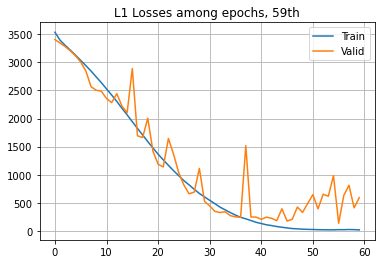

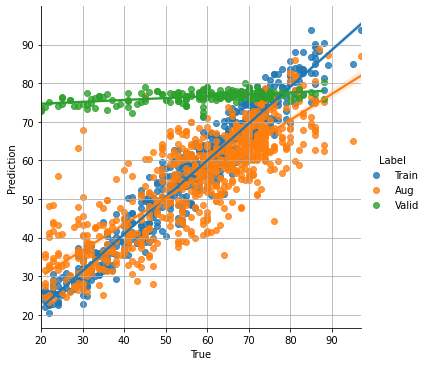

Epoch 61 / 100, BEST MAE 9.640
[train] 51.6 sec [train] 75.7 sec [eval] 12.2 sec 
[TRAIN]:: Loss=15.684 Mae=3.146 Rmse=3.729 Corr=0.972 
[AUGME]:: Loss=91.086 Mae=7.302 Rmse=9.322 
[VALID]:: Loss=246.765 Mae=12.024 Rmse=15.526 Corr=0.669 
Epoch 62 / 100, BEST MAE 9.640
[train] 49.5 sec [train] 73.6 sec [eval] 12.4 sec 
[TRAIN]:: Loss=14.288 Mae=3.011 Rmse=3.525 Corr=0.974 
[AUGME]:: Loss=87.365 Mae=7.108 Rmse=9.143 
[VALID]:: Loss=160.640 Mae=9.941 Rmse=12.542 Corr=0.693 
Epoch 63 / 100, BEST MAE 9.640
[train] 49.4 sec [train] 75.0 sec [eval] 12.6 sec 
Saving ...
[TRAIN]:: Loss=12.079 Mae=2.805 Rmse=3.226 Corr=0.978 
[AUGME]:: Loss=80.627 Mae=6.766 Rmse=8.764 
[VALID]:: Loss=143.725 Mae=9.523 Rmse=11.862 Corr=0.701 
Epoch 64 / 100, BEST MAE 9.523
[train] 49.8 sec [train] 76.9 sec [eval] 13.1 sec 
[TRAIN]:: Loss=11.686 Mae=2.766 Rmse=3.145 Corr=0.979 
[AUGME]:: Loss=78.235 Mae=6.700 Rmse=8.674 
[VALID]:: Loss=214.640 Mae=11.400 Rmse=14.458 Corr=0.698 
Epoch 65 / 100, BEST MAE 9.523
[tra

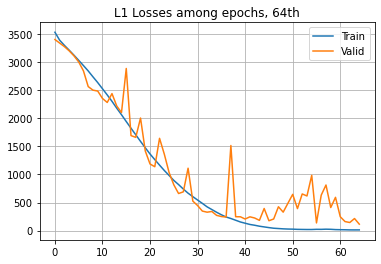

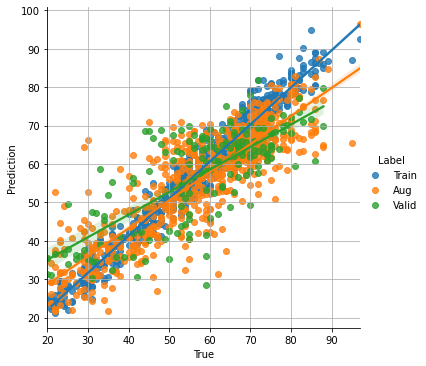

Epoch 66 / 100, BEST MAE 8.771
[train] 50.8 sec [train] 74.7 sec [eval] 12.4 sec 
[TRAIN]:: Loss=11.492 Mae=2.722 Rmse=3.073 Corr=0.980 
[AUGME]:: Loss=76.095 Mae=6.537 Rmse=8.519 
[VALID]:: Loss=159.032 Mae=9.893 Rmse=12.461 Corr=0.718 
Epoch 67 / 100, BEST MAE 8.771
[train] 49.9 sec [train] 76.3 sec [eval] 13.7 sec 
[TRAIN]:: Loss=11.276 Mae=2.708 Rmse=3.030 Corr=0.980 
[AUGME]:: Loss=75.425 Mae=6.505 Rmse=8.448 
[VALID]:: Loss=627.179 Mae=20.266 Rmse=24.799 Corr=0.261 
Epoch 68 / 100, BEST MAE 8.771
[train] 50.6 sec [train] 75.6 sec [eval] 14.2 sec 
[TRAIN]:: Loss=11.442 Mae=2.758 Rmse=3.076 Corr=0.980 
[AUGME]:: Loss=75.485 Mae=6.449 Rmse=8.471 
[VALID]:: Loss=473.202 Mae=17.378 Rmse=21.530 Corr=0.492 
Epoch 69 / 100, BEST MAE 8.771
[train] 53.7 sec [train] 78.3 sec [eval] 13.3 sec 
[TRAIN]:: Loss=11.291 Mae=2.734 Rmse=3.044 Corr=0.980 
[AUGME]:: Loss=75.235 Mae=6.560 Rmse=8.514 
[VALID]:: Loss=1060.064 Mae=28.919 Rmse=32.367 Corr=0.514 
Epoch 70 / 100, BEST MAE 8.771
[train] 52.2 

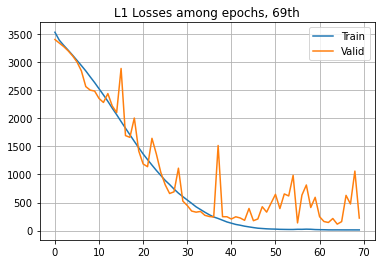

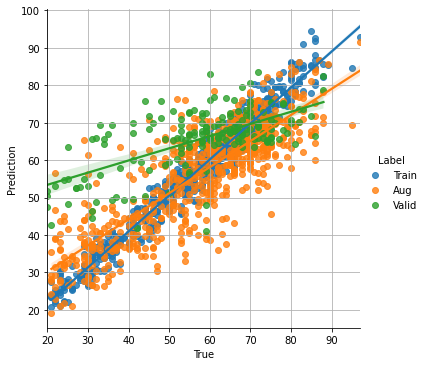

Epoch 71 / 100, BEST MAE 8.771
[train] 50.9 sec [train] 76.3 sec [eval] 13.2 sec 
[TRAIN]:: Loss=13.569 Mae=2.946 Rmse=3.408 Corr=0.976 
[AUGME]:: Loss=81.563 Mae=6.949 Rmse=8.849 
[VALID]:: Loss=203.485 Mae=11.094 Rmse=14.070 Corr=0.695 
Epoch 72 / 100, BEST MAE 8.771
[train] 52.1 sec [train] 78.7 sec [eval] 12.8 sec 
[TRAIN]:: Loss=13.601 Mae=2.960 Rmse=3.417 Corr=0.976 
[AUGME]:: Loss=83.841 Mae=7.003 Rmse=8.944 
[VALID]:: Loss=665.885 Mae=22.468 Rmse=25.638 Corr=0.528 
Epoch 73 / 100, BEST MAE 8.771
[train] 52.2 sec [train] 76.0 sec [eval] 12.6 sec 
[TRAIN]:: Loss=12.899 Mae=2.871 Rmse=3.328 Corr=0.977 
[AUGME]:: Loss=90.527 Mae=7.190 Rmse=9.246 
[VALID]:: Loss=1038.605 Mae=28.472 Rmse=32.035 Corr=0.506 
Epoch 74 / 100, BEST MAE 8.771
[train] 51.9 sec [train] 76.6 sec [eval] 13.0 sec 
[TRAIN]:: Loss=12.721 Mae=2.879 Rmse=3.340 Corr=0.977 
[AUGME]:: Loss=77.482 Mae=6.759 Rmse=8.615 
[VALID]:: Loss=820.157 Mae=23.843 Rmse=28.387 Corr=-0.254 
Epoch 75 / 100, BEST MAE 8.771
[train] 51.

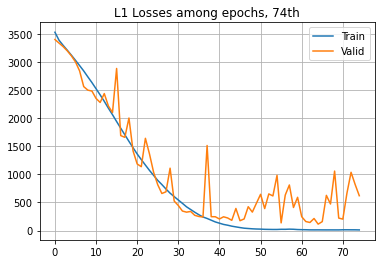

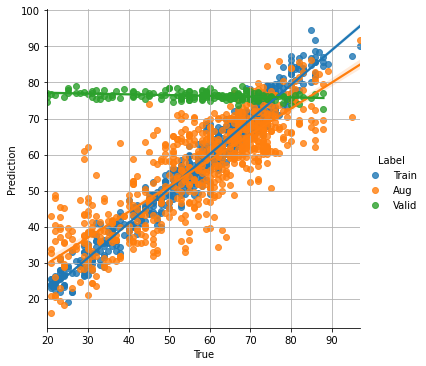

Epoch 76 / 100, BEST MAE 8.771
[train] 53.6 sec [train] 84.3 sec [eval] 14.3 sec 
[TRAIN]:: Loss=10.998 Mae=2.653 Rmse=3.003 Corr=0.980 
[AUGME]:: Loss=84.935 Mae=7.145 Rmse=9.009 
[VALID]:: Loss=814.317 Mae=24.414 Rmse=28.335 Corr=0.496 
Epoch 77 / 100, BEST MAE 8.771
[train] 54.0 sec [train] 79.2 sec [eval] 13.5 sec 
[TRAIN]:: Loss=13.430 Mae=2.873 Rmse=3.364 Corr=0.976 
[AUGME]:: Loss=76.386 Mae=6.714 Rmse=8.553 
[VALID]:: Loss=573.381 Mae=18.779 Rmse=23.676 Corr=-0.163 
Epoch 78 / 100, BEST MAE 8.771
[train] 53.0 sec [train] 77.7 sec [eval] 13.0 sec 
[TRAIN]:: Loss=11.713 Mae=2.763 Rmse=3.123 Corr=0.979 
[AUGME]:: Loss=70.172 Mae=6.309 Rmse=8.167 
[VALID]:: Loss=606.684 Mae=19.645 Rmse=24.377 Corr=0.069 
Epoch 79 / 100, BEST MAE 8.771
[train] 53.6 sec [train] 78.5 sec [eval] 12.6 sec 
[TRAIN]:: Loss=12.753 Mae=2.829 Rmse=3.262 Corr=0.977 
[AUGME]:: Loss=75.850 Mae=6.711 Rmse=8.514 
[VALID]:: Loss=681.840 Mae=22.142 Rmse=25.927 Corr=0.530 
Epoch 80 / 100, BEST MAE 8.771
[train] 50.6

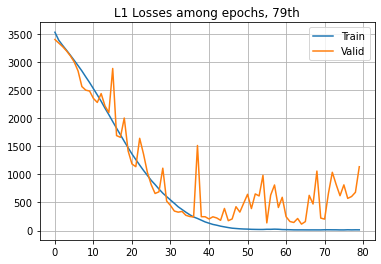

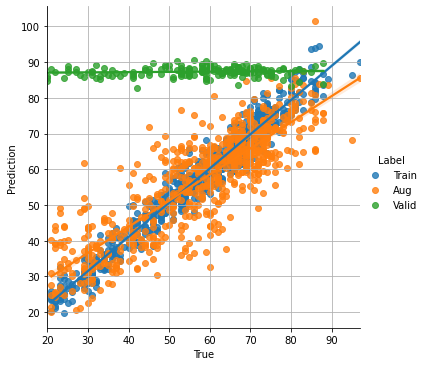

Epoch 81 / 100, BEST MAE 8.771
[train] 50.1 sec [train] 74.0 sec [eval] 12.3 sec 
[TRAIN]:: Loss=12.321 Mae=2.809 Rmse=3.219 Corr=0.978 
[AUGME]:: Loss=77.999 Mae=6.698 Rmse=8.646 
[VALID]:: Loss=720.129 Mae=21.870 Rmse=26.575 Corr=-0.236 
Epoch 82 / 100, BEST MAE 8.771
[train] 50.3 sec [train] 76.5 sec [eval] 13.1 sec 
[TRAIN]:: Loss=11.154 Mae=2.697 Rmse=3.053 Corr=0.980 
[AUGME]:: Loss=77.582 Mae=6.653 Rmse=8.615 
[VALID]:: Loss=134.160 Mae=9.305 Rmse=11.467 Corr=0.703 
Epoch 83 / 100, BEST MAE 8.771
[train] 53.0 sec [train] 77.7 sec [eval] 13.1 sec 
[TRAIN]:: Loss=11.432 Mae=2.720 Rmse=3.093 Corr=0.980 
[AUGME]:: Loss=78.182 Mae=6.677 Rmse=8.644 
[VALID]:: Loss=207.078 Mae=11.358 Rmse=14.228 Corr=0.636 
Epoch 84 / 100, BEST MAE 8.771
[train] 54.5 sec 

KeyboardInterrupt: 

In [14]:
for fold in range(16, cfg.folds):
    
    print(f'Fold {fold+1} / {cfg.folds}')
    mlflow.start_run(run_name=f'{today()} Fold {fold+1}')
    mlflow.log_params(params)
    mlflow.set_tags({
        'fold': fold+1
    })

    model, dps, res = run(cfg, fold, fold_db, mlflow=mlflow)
    models.append(model)
    packets.append(dps)
    
    cfg.test = True
    model, tst_dp, tst_res = eval(model, fn_lst, tst_dp, cfg, fold=None)
    
    df = pd.concat([make_df(res[0], 'Train'),
                   make_df(res[1], 'Valid'),
                   make_df(tst_res, 'Test')], ignore_index=True)
    
    tst_dp.corr.update(df[df['Label'] == 'Test'].corr().Prediction['True'])
    tst_dp.refresh()
    
    # Show Holdout testset information
    tst_dp.info('Holdout test')
    sns.lmplot(data=df, x='True', y='Prediction', hue='Label')
    plt.grid()
    plt.show()
    
    if test_db:
        data = gather_data(f=fold, test=tst_dp)
        write_db(test_db, data)
    
    torch.cuda.empty_cache()
    clear_output(wait=True)

## Ensemble

### Naive Averaging

In [39]:
# Ensemble
preds = dict()
models = glob('./models/ensembles/*.pth')
for fold, state in enumerate(models):
    
    model, device = load_model('resnet', verbose=False)
    model = torch.load(state)
    
    model, (_, _, _), tst_preds = eval(model, True, None, None, resize, device, batch_size,
                                      loss_fn, mae_fn, rmse_fn,
                                      [], [], [])
    
    preds[f'model_{fold}'] = list(map(float, tst_preds[1]))
    
ensemble_results = pd.DataFrame(preds)
ensemble_results['Avg'] = ensemble_results.mean(axis=1)
ensemble_results['True'] = list(map(float, tst_preds[0]))

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


In [64]:
def result_plot(df):
    
    avg = torch.Tensor(ensemble_results['Avg'])
    tru = torch.Tensor(ensemble_results['True'])
    
    corr = ensemble_results.corr()['True']['Avg']
    mae_fn, rmse_fn = nn.L1Loss(), RMSELoss()
    
    print(f'Ensemble Results')
    print(f'MAE  = {float(mae_fn(avg, tru)):.3f}')
    print(f'RMSE = {float(rmse_fn(avg, tru)):.3f}')
    print(f'CORR = {corr:.3f}')
    
    sns.lmplot(data=ensemble_results, x='True', y='Avg')
    plt.grid()
    plt.show()

Ensemble Results
MAE  = 7.025
RMSE = 8.598
CORR = 0.854


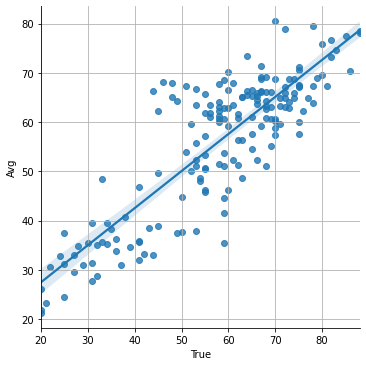

In [65]:
result_plot(ensemble_results)

### Blender

In [7]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
class CFG:
    
    model_name='resnet'
    dropout=0.1
    use_last_layer=True

In [10]:
class Ensemble(nn.Module):
    
    def __init__(self, model_list, CFG):
        super(Ensemble, self).__init__()
        
        self.cfg = CFG
        self.dropout = self.cfg.dropout
        self.models = dict()
        
        for idx, model_path in enumerate(model_list):
            
            model, device = load_model(self.cfg.model_name, verbose=False)
            model = torch.load(model_path)
            if not self.cfg.use_last_layer:
                model.fc = Identity()
                
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list) * 128, 128),
                    nn.Dropout(self.dropout),
                    nn.Linear(128, 1)
#                     nn.Dropout(self.dropout)
                )
                
            else:
                self.last_layer = nn.Sequential(
                    nn.Linear(len(model_list), 1),
#                     nn.Dropout(self.dropout)
                )
                
            for param in model.parameters():
                param.requires_grad = False
                
            self.models[idx] = model
        
    def forward(self, x):
        
        vectors = list()
        for idx, model in self.models.items():
            vectors.append(model(x))
            
        x = torch.cat(vectors, dim=1)
        x = self.last_layer(x)
        
        return x

In [11]:
model_list = glob('./models/ensembles/rough/*.pth')
model_list.sort()
cfg = CFG()
cfg.use_last_layer = True
model = Ensemble(model_list, cfg).to(device)
with torch.no_grad():
    model.last_layer[0].weight.fill_(1 / len(model_list))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.
Model Resnet is selected.


## SFCN Test

In [53]:
resnet, _ = load_model('resnet', verbose=True)

Model Resnet is selected.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 96, 48, 48]           2,352
       BatchNorm3d-2       [-1, 16, 96, 48, 48]              32
              ReLU-3       [-1, 16, 96, 48, 48]               0
         MaxPool3d-4       [-1, 16, 48, 24, 24]               0
            Conv3d-5       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-6       [-1, 16, 48, 24, 24]              32
              ReLU-7       [-1, 16, 48, 24, 24]               0
            Conv3d-8       [-1, 16, 48, 24, 24]           6,912
       BatchNorm3d-9       [-1, 16, 48, 24, 24]              32
             ReLU-10       [-1, 16, 48, 24, 24]               0
       BasicBlock-11       [-1, 16, 48, 24, 24]               0
           Conv3d-12       [-1, 32, 24, 12, 12]          13,824
      BatchNorm3d-13       [-1, 32, 24, 12, 12]              64
             

In [119]:
cfg.model_name = 'sfcn'
model, cfg.device = load_model(cfg.model_name, verbose=False)
optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

Model Sfcn is selected.


In [120]:
state_dict = torch.load('../UKBiobank_deep_pretrain/brain_age/run_20190719_00_epoch_best_mae.p')
state_dict = dict(state_dict)
keys = list(map(lambda x: x.split('module.')[-1], state_dict.keys()))
state_dict = {k: v for k, v in zip(keys, state_dict.values())}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [52]:
summary(model, input_size=(1, 160, 192, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 32, 160, 192, 160]             896
       BatchNorm3d-2    [-1, 32, 160, 192, 160]              64
         MaxPool3d-3       [-1, 32, 80, 96, 80]               0
              ReLU-4       [-1, 32, 80, 96, 80]               0
            Conv3d-5       [-1, 64, 80, 96, 80]          55,360
       BatchNorm3d-6       [-1, 64, 80, 96, 80]             128
         MaxPool3d-7       [-1, 64, 40, 48, 40]               0
              ReLU-8       [-1, 64, 40, 48, 40]               0
            Conv3d-9      [-1, 128, 40, 48, 40]         221,312
      BatchNorm3d-10      [-1, 128, 40, 48, 40]             256
        MaxPool3d-11      [-1, 128, 20, 24, 20]               0
             ReLU-12      [-1, 128, 20, 24, 20]               0
           Conv3d-13      [-1, 256, 20, 24, 20]         884,992
      BatchNorm3d-14      [-1, 256, 20,

In [122]:
cfg.test = True
test_dset = MyDataset(cfg, augment=False, fold=None)
test_dl = DataLoader(test_dset, batch_size=16)

In [123]:
from tqdm import tqdm

In [124]:
mae = nn.L1Loss()

In [125]:
len(test_dl)

175

In [141]:
model.to(cfg.device)
model.eval()
y_preds, ys = [], []
age_bins = torch.tensor([42+i for i in range(40)])
with torch.no_grad(): # to not give loads on GPU... :(
    for i, (x, y) in tqdm(enumerate(test_dl)):

        x, y = F.interpolate(x, size=(160, 192, 160)).to(cfg.device), y.to(cfg.device)

        y_pred = model.forward(x)[0].to(cfg.device)
        y_pred = (np.exp(y_pred.squeeze().cpu()) * age_bins).sum()
#         y_pred = y_pred.max(axis=1).indices.squeeze()
#         y_pred += 42
        y_preds.append(y_pred)
        ys.append(y.squeeze())
#             loss = mae(y_pred, y.squeeze())


torch.cuda.empty_cache()

175it [01:34,  1.85it/s]


In [142]:
y_preds

[tensor(61.6599),
 tensor(61.7157),
 tensor(61.7013),
 tensor(61.6005),
 tensor(61.7016),
 tensor(61.6746),
 tensor(61.7836),
 tensor(61.7749),
 tensor(61.6993),
 tensor(61.7976),
 tensor(61.5874),
 tensor(61.7681),
 tensor(61.6228),
 tensor(61.7712),
 tensor(61.7092),
 tensor(61.6922),
 tensor(61.6985),
 tensor(61.6919),
 tensor(61.7777),
 tensor(61.6981),
 tensor(61.7683),
 tensor(61.6945),
 tensor(61.7273),
 tensor(61.7181),
 tensor(61.6787),
 tensor(61.6604),
 tensor(61.7700),
 tensor(61.6451),
 tensor(61.6265),
 tensor(61.7153),
 tensor(61.7775),
 tensor(61.7490),
 tensor(61.6858),
 tensor(61.7030),
 tensor(61.7142),
 tensor(61.6119),
 tensor(61.6881),
 tensor(61.6945),
 tensor(61.7397),
 tensor(61.7046),
 tensor(61.7193),
 tensor(61.6711),
 tensor(61.7765),
 tensor(61.7687),
 tensor(61.6858),
 tensor(61.7460),
 tensor(61.7668),
 tensor(61.7644),
 tensor(61.6633),
 tensor(61.7968),
 tensor(61.6773),
 tensor(61.7042),
 tensor(61.7881),
 tensor(61.6017),
 tensor(61.6908),
 tensor(61

In [128]:
ys

[tensor([62.], device='cuda:0'),
 tensor([68.], device='cuda:0'),
 tensor([74.], device='cuda:0'),
 tensor([55.], device='cuda:0'),
 tensor([86.], device='cuda:0'),
 tensor([59.], device='cuda:0'),
 tensor([29.], device='cuda:0'),
 tensor([70.], device='cuda:0'),
 tensor([68.], device='cuda:0'),
 tensor([67.], device='cuda:0'),
 tensor([65.], device='cuda:0'),
 tensor([20.], device='cuda:0'),
 tensor([55.], device='cuda:0'),
 tensor([62.], device='cuda:0'),
 tensor([64.], device='cuda:0'),
 tensor([48.], device='cuda:0'),
 tensor([75.], device='cuda:0'),
 tensor([71.], device='cuda:0'),
 tensor([58.], device='cuda:0'),
 tensor([62.], device='cuda:0'),
 tensor([69.], device='cuda:0'),
 tensor([66.], device='cuda:0'),
 tensor([45.], device='cuda:0'),
 tensor([56.], device='cuda:0'),
 tensor([65.], device='cuda:0'),
 tensor([63.], device='cuda:0'),
 tensor([58.], device='cuda:0'),
 tensor([60.], device='cuda:0'),
 tensor([20.], device='cuda:0'),
 tensor([51.], device='cuda:0'),
 tensor([5